# Return Level Variation by Climate Index
```{glue:figure} CI_mag_inLocation
:scale: 35%
:align: right
```

In this notebook, we'll run analysis for the various contributions to extreme sea levels through the lens of the nonstationary GEV analysis. Here we follow methodolody from {cite:t}`marra_advancing_2023` and {cite:t}`sweet_implications_2024`, which use the nonstationary GEV analysis of {cite:t}`mendez_analyzing_2007` to analyze the influence of climatic patterns like ENSO and PDO (for example) on extreme sea levels. We will test a host of different climate indices to determine which has the most influence over the extreme event modeling.  

## Setup

First we'll import the necessary functions, set up our directories, and get everything ready for plotting. This should be the same as we did previously in the [nonstationary extremes](notebooks/nonstationaryGEV/monthly_extremes_non-stationaryGEV.ipynb) notebook.

In [1]:
%run ../0_1_setup.ipynb
import sys
import json
from scipy.stats import chi2
sys.path.append("../../python/nonstationaryGEV")
import helpers, models, plotting, imports

base_dir = Path(data_dir).parent
dirs = imports.make_directoryDict(base_dir)
model_output_dir = dirs['model_output_dir']
from helpers import adjust_w_for_plotting
import xarray as xr

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in create_collection")


Using custom paths from config_env.py
Data directory: /Users/jfiedler/Projects/SL_Indicators/data
Output directory: /Users/jfiedler/Projects/SL_Indicators/output
Using custom paths from config_env.py
Data directory: /Users/jfiedler/Projects/SL_Indicators/data
Output directory: /Users/jfiedler/Projects/SL_Indicators/output


## Compile data 
```{caution}

Before running this, you will need to run the [non-stationary models](notebooks/nonstationaryGEV/monthly_extremes_non-stationaryGEV.ipynb) notebook first! Grab some coffee and get ready for some fun.
```

In the following codes we are just compiling the output and results from those models that have been saved to "model_output_dir" directory. The methodology contained herein follows {cite:t}`sweet_implications_2024`.

In [2]:
rsl_hourly = xr.open_dataset(data_dir/ 'rsl_hawaii_noaa.nc')
rsl_hourly['station_name'] = rsl_hourly['station_name'].astype(str)

station_ids = rsl_hourly.station_id.values
runWithoutModel = True
returnPeriod = [2,10,50,100]
year0plot = 1993
saveToFile = True
numProcesses = 8 # number of processes to run in parallel, select 1 if you want to run in serial
climateIndex = ['PMM','BEST','ONI','PDO','AO','PNA','TNA'] #add more, if needed


Establish directories if you have not already done so. (They should be already established if you've run the [non-stationary models](notebooks/nonstationaryGEV/monthly_extremes_non-stationaryGEV.ipynb) notebook already. Have you done that? You should. It'll be fun, try it.)

In [3]:
station_ids

array(['1617760', '1619910', '1617433', '1612480', '1615680', '1612340',
       '1611400'], dtype='<U7')

In [4]:
# check if output directory exists, if not create it
if not output_dir.exists():
    output_dir.mkdir(parents=True)

# check if model output directory exists, if not create it
if not dirs['model_output_dir'].exists():
    dirs['model_output_dir'].mkdir(parents=True)

# make sub-directories for each station in rsl_hourly in model_output_dir
for sid in rsl_hourly.station_id:
    sidString = str(sid.values)
    # maybe needs some leading zeros, for now we'll leave it.
    station_dir = dirs['model_output_dir'] / sidString
    if not station_dir.exists():
        station_dir.mkdir(parents=True)

The following section will run the covariate in scale and location model for every climate covariate in the covariateIndex variable. Only run this section 1 time. 

In [5]:
for stationID in ['1612340']:
# for stationID in station_ids:
    print(f'Processing stationID: {stationID}')
    #only run if best_params.json does not exist
    best_params_file = dirs['model_output_dir'] / str(stationID) / 'best_params.json'
    if best_params_file.exists():
        print(f'Best parameters file already exists for stationID {stationID}, skipping...')
        continue

    # Preallocate the significance array
    SignifCvte1 = np.zeros(len(climateIndex))
    SignifCvte2_loc = np.zeros(len(climateIndex))
    SignifCvte2_T = np.zeros(len(climateIndex))

    runWithoutModel=True
    numProcesses = 8
    # run the models for all recordIDs
    # for recordID in recordIDs:
    _, _, _, _, _, _, x_N, w_N, wcomp, SignifN = models.run_noClimateIndex_models(rsl_hourly,stationID,runWithoutModel,dirs, returnPeriod, CIname='None', nproc=numProcesses)

    # you can set runWithoutModel=False if you want to re-run the models
    STNDtoMHHW, station_name, year0, mm, ampCvte1, SignifCvte1 = models.run_CI_models(rsl_hourly,stationID,runWithoutModel,dirs, returnPeriod, climateIndex,x_N, w_N, wcomp, SignifN, nproc=numProcesses)


Processing stationID: 1612340
Best parameters file already exists for stationID 1612340, skipping...


#### Choose station and climate indices
Here we'll use all tested indices

In [6]:
climateIndex = ['AO','BEST','ONI','PDO','PMM','PNA','TNA']

# get list of all directories in dirs['model_output_dir']
dirs_list = os.listdir(dirs['model_output_dir'])

# only keep the directories that are numbers
stationIDs = [int(d) for d in dirs_list if d.isdigit()]


# get station names from the best_params.json files
station_names = {}
for stationID in stationIDs:
    jsonpath = Path(dirs['model_output_dir']) / str(stationID) / 'best_params.json'
    with open(jsonpath, 'r') as f:
        output = json.load(f)
        station_names[stationID] = output['modelInfo']['station_name']

# sort the station names by the stationID
station_names = {k: v for k, v in sorted(station_names.items(), key=lambda item: item[0])}

station_names

{1611400: 'Nawiliwili',
 1612340: 'Honolulu',
 1612480: 'Mokuoloe',
 1615680: 'Kahului, Kahului Harbor',
 1617433: 'Kawaihae',
 1617760: 'Hilo, Hilo Bay, Kuhio Bay',
 1619910: 'Sand Island, Midway Islands'}

#### Create a dataframe
This will hold information about the amplitude of the tested climate index signals in the location parameter of the best-fit nonstationary GEV model.

In [7]:
#%%
for stationID in station_ids:
    # Initialize an empty list to store results
    results = []
    SignifCvte1 = np.zeros(len(climateIndex))
    w_nodal = np.zeros(len(climateIndex))
    w_cvte1 = np.zeros(len(climateIndex))

    for i in np.arange(0, len(climateIndex)):
        #read first value of w from trend_params.json
        nodal_params = 'nodal_params.json'
        jsonpath = Path(dirs['model_output_dir']) / str(stationID) / nodal_params
        with open(jsonpath, 'r') as f:
            output = json.load(f)
            w_nodal[i] = output['w'][0]

        covariate_params = f'cvte_location_params_{climateIndex[i]}.json'

        # Create the full path for the JSON file
        jsonpath = Path(dirs['model_output_dir']) / str(stationID) / covariate_params

        # Open and read the JSON file
        with open(jsonpath, 'r') as f:
            output = json.load(f)
        w, mio, standard_error,x = (np.array(output[key]) for key in ['w', 'mio', 'standard_error','x'])

        wfull = helpers.adjust_w_for_plotting(x,w)

        # prepend standard error with 0 to match the size of w
        standard_error = np.insert(standard_error, 0, 0)

        standard_error = helpers.adjust_w_for_plotting(x,standard_error)

        # Store the results in a list
        results.append({
            'Climate Index': climateIndex[i],
            'CI param': wfull[10],  
            'Standard Error of CI param': standard_error[10]
        })

        # Compute deviance statistic
        w_cvte1[i] = w[0]
        diffe = w_cvte1[i] - w_nodal[i]
        p = 1
        SignifCvte1[i] = chi2.cdf(2 * diffe, p)

    # Convert the results list to a DataFrame
    df_cvteLocation = pd.DataFrame(results)

    # add Significance to the dataframe
    df_cvteLocation['Significance (over Nodal)'] = SignifCvte1


    # add the lags from CI_correlation_results.csv
    # CI_correlation_results = pd.read_csv(Path(dirs['CI_dir']) / 'CI_correlation_results_setLag.csv')

    #rename climateIndex to Climate Index
    # CI_correlation_results = CI_correlation_results.rename(columns={'climateIndex':'Climate Index'})

    # extract only the stationID of interest
    # CI_corr = CI_correlation_results[CI_correlation_results['stationID'].astype(str) == str(stationID)]
    # add the lags from CI_correlation_results['lag'] to df_cvteLocation, matching on Climate Index and stationID
    # df_cvteLocation = df_cvteLocation.merge(CI_corr[['Climate Index','lag']], on='Climate Index')


    #save to a json file
    df_cvteLocation.to_json(Path(dirs['model_output_dir']) / str(stationID) / 'cvte_location_params_ALL.json')
    df_cvteLocation


### Investigate the parameter magnitudes and lags

First let's take a look at an example dataframe showing the influence of each climate index as covariate in the nonstationary GEV model.

In [8]:
stationID = station_ids[3]
df_cvteLocation = pd.read_json(Path(dirs['model_output_dir']) / str(stationID) / 'cvte_location_params_ALL.json')
df_cvteLocation

,Climate Index,CI param,Standard Error of CI param,Significance (over Nodal)
0,AO,0.012489,0.004409,0.995937
1,BEST,0.027963,0.003691,1.000000
2,ONI,0.025862,0.003538,1.000000
3,PDO,0.026750,0.004364,1.000000
4,PMM,0.015563,0.003702,0.999979
5,PNA,-0.004978,0.004948,0.749199
6,TNA,-0.019517,0.004663,0.999974


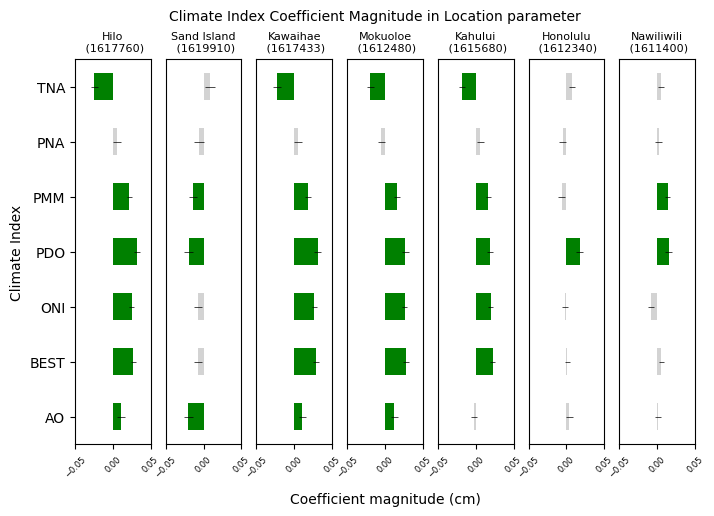

In [9]:
import matplotlib.pyplot as plt
import numpy as np

fig,ax = plt.subplots(1,len(station_ids),figsize=(8,5))

for i,stationID in enumerate(station_ids):

    station_name = station_names[int(stationID)]
    # Create the full path for the JSON file
    jsonpath = Path(dirs['model_output_dir']) / str(stationID) / 'cvte_location_params_ALL.json'

     # Open and read the JSON file
    with open(jsonpath, 'r') as f:
        output = json.load(f)
    
    df_cvteLocation = pd.DataFrame(output)

    # Define colors based on significance
    location_colors = np.where(df_cvteLocation['Significance (over Nodal)']>0.95, 'green', 'lightgray')


    # Plot the Location parameter with custom colors for significance
    df_cvteLocation.plot(
        x='Climate Index',
        y='CI param',
        kind='barh',  # Horizontal bar plot
        ax=ax[i],
        color=location_colors
    )

    # add error bars
    ax[i].errorbar(df_cvteLocation['CI param'], df_cvteLocation.index, 
                   xerr=df_cvteLocation['Standard Error of CI param'], fmt='none', ecolor='black', capsize=0, lw =0.5)
    
    # add lag to each bar
    
    # halign = 'left'
    # for j in range(len(df_cvteLocation)):
    #     xoffset = 0.001
    #     if df_cvteLocation['CI param'].iloc[j]<0:
    #         xoffset = -df_cvteLocation['CI param'].iloc[j]+xoffset
    #     ax[i].text(df_cvteLocation['CI param'].iloc[j]+xoffset, j+0.2, '{:.0f}'.format(df_cvteLocation['lag'].iloc[j]), fontsize=6, ha=halign, va='center', color='black')


    ax[i].legend().set_visible(False)

    # Remove y-axis label
    ax[i].set_ylabel('')

    # remove x-tick labels
    if i != 0:
        ax[i].set_yticklabels([])
        ax[i].set_yticks([])

    # set all axes to the same scale
    ax[i].set_xlim(-0.05,0.05)

    # set xticks to have only 3 ticks
    ax[i].set_xticks(np.linspace(-0.05,0.05,3))

    # rotate xticks
    ax[i].tick_params(axis='x', rotation=45)

    # set fontsize of xticks
    ax[i].tick_params(axis='x', labelsize=6)
    ax[i].set_title(station_name.split(',')[0].strip() + '\n (' + str(stationID) + ')', fontsize=8)

    # add super title
    fig.suptitle('Climate Index Coefficient Magnitude in Location parameter', fontsize=10)

    # add y label to full plot
    ax[0].set_ylabel('Climate Index', fontsize=10)

    # add x label to full plot
    ax[3].set_xlabel('Coefficient magnitude (cm)', fontsize=10, labelpad=10)


# glue figure
glue("CI_mag_inLocation",fig,display=False)

plt.savefig(output_dir / 'CI_mag_location.png', dpi=300, bbox_inches='tight')




```{glue:figure} CI_mag_inLocation
:name: "CI_mag_inLocation"

A comparison of the magnitudes of the climate index covariate in the location parameter of the nonstationary GEV model. The tested climate indices are shown in green when their inclusion in the total model (after the inclusion of the nodal cycle) is considered a significant contribution. Coefficients which do not offer a significant improvement over the Nodal model are shown in gray. Note that all climate indices considered here are coincident in time with the monthly max signal, negating any potential phase lags between the two time series.
```

## Plot all models in time
Next we'll look at all models and how they compare.

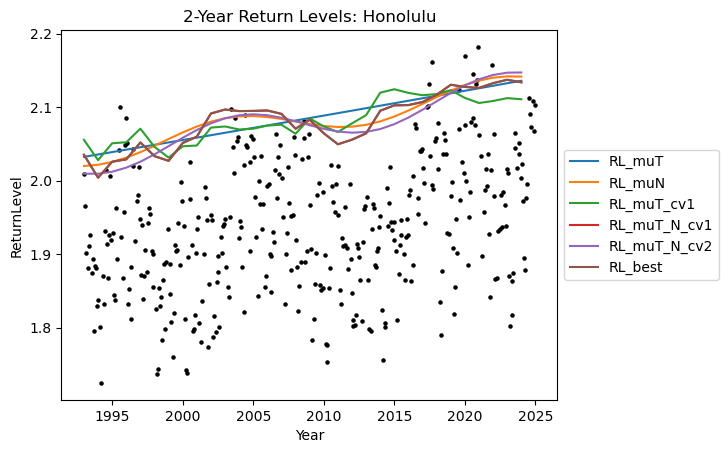

In [10]:
# Only do Honolulu for now
stationID = station_ids[5]

modelTypes = ['RL_muT', 'RL_muN','RL_muT_cv1','RL_muT_cv2','RL_muT_N_cv1','RL_muT_N_cv2','RL_best']

for modelType in modelTypes:
    modelName = modelType + '.nc'
    modelPath = Path(dirs['model_output_dir'] / str(stationID) / modelName)

    if not modelPath.exists():
        continue
    model = xr.open_dataset(modelPath)

    model['ReturnLevel'].sel(ReturnPeriod=2).plot(label=modelType)

plt.legend()
# put the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# read the json file for best model
jsonpath = Path(dirs['model_output_dir']) / str(stationID) / 'best_params.json'
with open(jsonpath, 'r') as f:
    output = json.load(f)
    modelInfo = output['modelInfo']
    params = output['w']
    x = output['x']

time = modelInfo['year0'] + pd.Series(modelInfo['t'])
plt.scatter(time, modelInfo['monthlyMax'], color='k', label='Monthly Maxima', s=5)

plt.title('2-Year Return Levels: ' + model.attrs['station_name'])

w = helpers.adjust_w_for_plotting(x, params)

Now we'll save the parameter component amplitudes to our model output directory.

In [12]:
stationID = int(station_ids[3])

# read the json file for best model
jsonpath = Path(dirs['model_output_dir']) / str(stationID) / 'best_params.json'
with open(jsonpath, 'r') as f:
        output = json.load(f)
        modelInfo = output['modelInfo']
        params = output['w']
        x = output['x']
        
time = modelInfo['year0'] + pd.Series(modelInfo['t'])

w = helpers.adjust_w_for_plotting(x, params)
modelType = 'RL_best.nc'
model = xr.open_dataset(Path(dirs['model_output_dir']) / str(stationID) / modelType)
# fig, amps, ax = make_component_figure(w, modelInfo, model, time)

glue("location_components",fig,display=False)
glue("station",model.attrs['station_name'],display=False)


## Plot return level curves 
We'll plot them using the 2023 return levels.

In [13]:
import contextlib

def get_2000_2023_RL(best_params):
    """
    Calculate the return levels for the years 2023 and 2000 based on the best parameters.
    """
    ReturnPeriod = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50, 100]  # Example return periods in years
    years, RL, RL_high, RL_low = helpers.getTimeDependentReturnValue(
        best_params['modelInfo']['t'], 
        best_params['modelInfo']['covariate'], 
        best_params['w'], 
        best_params['x'], 
        ReturnPeriod, 
        best_params['mio']
    )
    year0 = best_params['modelInfo']['year0']
    years = years + year0

    # Find the index where years == 2023
    year_2023 = np.where(years == 2023)[0][0]
    year_2000 = np.where(years == 2000)[0][0]

    RLs2023 = RL[:, year_2023]
    RLs2000 = RL[:, year_2000]

    return RLs2023, RLs2000, ReturnPeriod



def get_amplitudes_and_tseries(STATION_ID,ReturnPeriod=[20]):
    """
    Get amplitudes and time series for a given station ID.
    
    Args:
        STATION_ID (str): The station ID to retrieve data for.
        
    Returns:
        tuple: A tuple containing the amplitudes and time series.
    """
    params_json = dirs['model_output_dir'] / str(STATION_ID) / 'best_params.json'

    if params_json.exists():
        print(f"Loading model parameters from: {params_json}")
        with open(params_json, 'r') as f:
            output = json.load(f)
            params = output['w']
            mio = output['mio']
            x = output['x']
            modelInfo = output['modelInfo']



        w_noLL = helpers.adjust_w_for_plotting(x, params)
        # insert arbitary log likelihood value at the start
        w = np.insert(w_noLL, 0, 400)
        w_best = w[w != 0]  # Remove any zero values

        x_seasonal = x[0:3]

        with contextlib.redirect_stdout(io.StringIO()):  # Suppress output
            # Calculate return levels for the best model
            years, RL_best, _, _ = helpers.getTimeDependentReturnValue(modelInfo['t'], modelInfo['covariate'], w_best, x, ReturnPeriod, mio)

        # Include only astronomical cycles
        w_nodal = w.copy()
        w_nodal = np.delete(w_nodal, [10, 11,12])

        # remove any zero values from w_nodal
        w_nodal = w_nodal[w_nodal != 0]
        x_nodal = x_seasonal + [0, 0, 0, 1]

        # if nodal is not included, remove it from x_nodal
        if x[6] == 0:
            x_nodal[6] = 0  # Ensure nodal component is zeroed out

        with contextlib.redirect_stdout(io.StringIO()):  # Suppress output
            years, RL_nodal, _, _ = helpers.getTimeDependentReturnValue(modelInfo['t'], modelInfo['covariate'], w_nodal, x_nodal, ReturnPeriod, mio)

        # Include only trend
        w_trend = w[0:11]
        if w_trend[10] != 0:
            w_trend = w_trend[w_trend != 0]  # Remove any zero values
            x_trend = x_seasonal + [1,0,0,0]
        else:
            w_trend = w_trend[w_trend != 0]  # Remove any zero values
            x_trend = x_seasonal + [0,0,0,0]

        with contextlib.redirect_stdout(io.StringIO()):  # Suppress output
            # Calculate return levels for the trend model
            years, RL_trend, _, _ = helpers.getTimeDependentReturnValue(modelInfo['t'], modelInfo['covariate'], w_trend, x_trend, ReturnPeriod, mio)

        # Include only MMA
        w_cvte = np.zeros_like(w)
        # Set w_cvte to match w up to index 13, but skip index 10
        w_cvte[:13] = w[:13]
        w_cvte[10] = 0  # Ensure index 10 is zeroed out
        w_cvte = w_cvte[w_cvte != 0]  # Remove any zero values

        # use x from original model, remove index 3 and 6 (trend and nodal)
        x_cvte = x.copy()
        x_cvte[3] = 0  # Remove trend component
        x_cvte[6] = 0  # Remove nodal component

        with contextlib.redirect_stdout(io.StringIO()):  # Suppress output
            # Calculate return levels for the MMA model
            years, RL_CI, _, _ = helpers.getTimeDependentReturnValue(modelInfo['t'], modelInfo['covariate'], w_cvte, x_cvte, ReturnPeriod, mio)

        # Seasonal Only model
        w_seasonal = w[:10]  # Use first 10 components (seasonal components
        w_seasonal = w_seasonal[w_seasonal != 0]  # Remove any zero values

        x_sea = x_seasonal + [0, 0, 0, 0]  # Use seasonal components only

        with contextlib.redirect_stdout(io.StringIO()):  # Suppress output
            # Calculate return levels for the seasonal model
            years, RL_seasonal,_,_ = helpers.getTimeDependentReturnValue(modelInfo['t'], None, w_seasonal, x_sea, ReturnPeriod, mio)


        # Create a clean DataFrame with all model variants
        df = pd.DataFrame({
            'years': years[:-1]+modelInfo['year0'],  # Remove last element to match RL arrays
            'RL_seasonal': RL_seasonal[0],  
            'RL_Trend': RL_trend[0], 
            'RL_Nodal': RL_nodal[0],
            'RL_CI': RL_CI[0],
            'RL_full': RL_best[0]
        })

        # zero out RL if not in the best model (x)
        if x[3] == 0:
            df['RL_Trend'] = 0.0
        if x[6] == 0:
            df['RL_Nodal'] = 0.0
        if x[4] == 0:
            df['RL_CI'] = 0.0

        # Add metadata
        df.attrs = {
            'return_period': ReturnPeriod[0],
            'station_id': modelInfo.get('recordID', 'Unknown'),
            'description': 'Time-dependent return levels by model component'
        }

        # print(f"DataFrame created with {len(df)} time points")
        # print(f"Columns: {list(df.columns)}")
        # print(f"Return Period: {ReturnPeriod[0]} years")

        # Calculate amplitude of each column, using  peak-to-peak amplitude
        amplitude = {
            'RL_Trend': 0.5*100*(df['RL_Trend'].iloc[-1] - df['RL_Trend'].iloc[0]),
            'RL_Nodal': 0.5*100*(df['RL_Nodal'].max() - df['RL_Nodal'].min()),
            'RL_CI': 0.5*100*(df['RL_CI'].max() - df['RL_CI'].min()),
            'RL_full': 0.5*100*(df['RL_full'].max() - df['RL_full'].min())
            }

    else:
        # make corresponding empty DataFrame
        df = pd.DataFrame(columns=['years', 'RL_seasonal', 'RL_Trend', 'RL_Nodal', 'RL_CI', 'RL_full'])
        df.attrs = {
            'return_period': ReturnPeriod[0],
            'station_id': STATION_ID,
            'description': 'Time-dependent return levels by model component'
        }
        amplitude = {
            'RL_Trend': 0.0,
            'RL_Nodal': 0.0,
            'RL_CI': 0.0,
            'RL_full': 0.0
        }   

    return df, amplitude

In [14]:
def get_plot_data(STATION_ID):
    """
    Get plot data for a given station ID.
    
    Args:
        STATION_ID (str): The station ID to retrieve data for.
        
    Returns:
        dict: A dictionary containing RL_best, best_params, df, amplitude, RLs2000, RLs2023, ReturnPeriod.
    """
    
    # open RL_best.nc
    RL_best = xr.open_dataset(f"{dirs['model_output_dir']}/{STATION_ID}/RL_best.nc")

    # open best_params.json
    with open(f"{dirs['model_output_dir']}/{STATION_ID}/best_params.json", 'r') as f:
        best_params = json.load(f)

    df, amplitude = get_amplitudes_and_tseries(STATION_ID, ReturnPeriod=[20])
    RLs2023, RLs2000, ReturnPeriod = get_2000_2023_RL(best_params)
    mhhw = best_params['modelInfo']['STNDtoMHHW']

    # make a dict of RL_best, best_params, df, amplitude, RLs2000, RLs2023, ReturnPeriod
    plot_data = {
        'RL_best': RL_best,
        'best_params': best_params,
        'df': df,
        'amplitude': amplitude,
        'RLs2023': RLs2023,
        'RLs2000': RLs2000,
        'ReturnPeriod': ReturnPeriod,
        'mhhw': mhhw
    }
    return plot_data


In [15]:
def plot_return_level_curves(ax, RLs2023, RLs2000, ReturnPeriod, mhhw, amplitude, best_params,df):
    """
    Plot return level curves for a station on the given axis.
    Args:
        ax (matplotlib.axes.Axes): Axis to plot on.
        RLs2023 (array): Return levels for 2023.
        RLs2000 (array): Return levels for 2000.
        ReturnPeriod (array): Return periods (years).
        mhhw (float): Mean higher high water reference.
        amplitude (dict): Amplitudes for each model component.
        best_params (dict): Model parameters and metadata.
    """
    # Plot return levels for 2023 and 2000
    ax.plot(ReturnPeriod, RLs2023-mhhw, label='Return Level 2023', color='k')
    ax.plot(ReturnPeriod, RLs2000-mhhw, label='Return Level 2000', color='k', linestyle='--')
    covariateName = best_params.get('modelInfo', {}).get('covariateName', 'Covariate')
    CIlabel = r'{} Contribution ($\pm$ {:.1f} cm)'.format(covariateName, amplitude["RL_CI"])

    # add an offset, which actual amplitude of the CI effect in 2023
    offset = df[df['years'] == 2023]['RL_CI'] - df[df['years'] == 2023]['RL_seasonal']
    offset = offset.values[0]
    offset = 0

    ax.fill_between(ReturnPeriod, RLs2023-mhhw+offset+0.01*amplitude['RL_CI'],
                    RLs2023-mhhw+offset-0.01*amplitude['RL_CI'], color='gray', alpha=0.2, label=CIlabel)

    # # Annotate amplitudes if available
    # if amplitude:
    #     for key, amp in amplitude.items():
    #         ax.text(0.98, 0.02 + 0.04 * list(amplitude.keys()).index(key), f'{key}: {amp:.1f} cm',
    #                 transform=ax.transAxes, fontsize=8, color='gray', ha='right', va='bottom')
    # Set log scale for x-axis (return period)
    ax.set_xscale('log')

    # make x-axis labels be 0.1, 1, 10, 100 years
    ax.set_xticks([0.1, 1, 10, 100])
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

    # set x-axis limits
    ax.set_xlim(0.1, 100)

    # add grid
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    ax.set_xlabel('Return Period (years)')
    ax.set_ylabel('Return Level (m, MHHW)')


    # Title with station ID
    station_id = best_params.get('modelInfo', {}).get('stationID', 'Unknown')
    station_name = best_params.get('modelInfo', {}).get('station_name', 'Unknown Station')
    ax.set_title(f'Return Level Curves for {station_name} ({station_id})')
    ax.legend()

Loading model parameters from: /Users/jfiedler/Projects/SL_Indicators/data/GEV_model_output/1612480/best_params.json
Time-dependent return values calculated


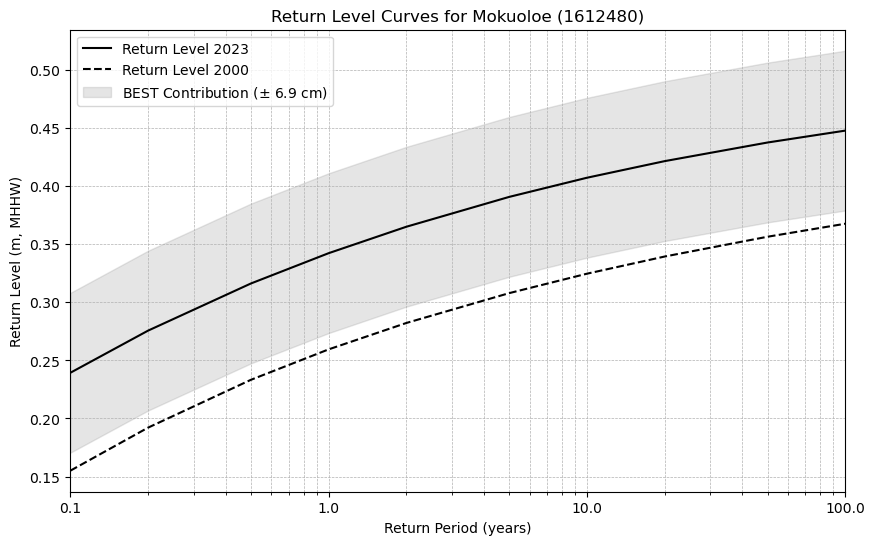

In [16]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
plot_data = get_plot_data(stationID)
plot_return_level_curves(ax, plot_data['RLs2023'], plot_data['RLs2000'], 
                         plot_data['ReturnPeriod'], plot_data['mhhw'],
                         plot_data['amplitude'], plot_data['best_params'],plot_data['df'])

#glue 
glue("return_level_curves_NS",fig,display=False)

# save figure
savepath = output_dir / f'ReturnLevelCurves_NS_{stationID}.png'
fig.savefig(savepath, bbox_inches='tight')

In [19]:
covariateName = plot_data['best_params'].get('modelInfo', {}).get('covariateName', 'Covariate')
ampCI = plot_data['amplitude'].get('RL_CI', 0)
ampCI = float(ampCI)

glue("covariateName",covariateName,display=False)
glue("ampCI",ampCI,display=False)

```{glue:figure} return_level_curves_NS
:name: "return_level_curves_NS"

Return level curves in 2023 and 2000 for the {glue:text}`station` tide gauge. The shaded area represents the influence of the {glue:text}`covariateName` covariate in the return levels, which can influence the location parameter by $\pm$ {glue:text}`ampCI:.2f` cm.
```

## Plot sub-annual contributions


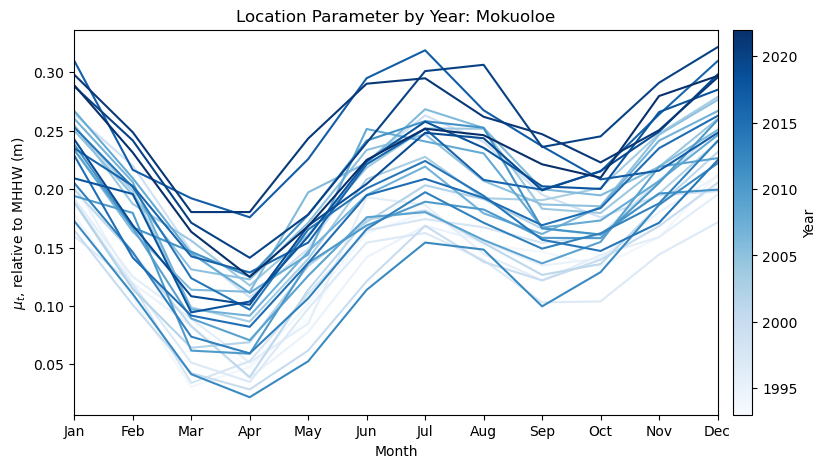

In [20]:
stationID = int(station_ids[3])
jsonpath = Path(dirs['model_output_dir']) / str(stationID) / 'best_params.json'
with open(jsonpath, 'r') as f:
    output = json.load(f)
    modelInfo = output['modelInfo']
    params = output['w']
    x = output['x']

w = helpers.adjust_w_for_plotting(x, params)    

# params should be a dictionary with the following
paramNames = ['b0','a0','g0','b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'bLT', 'bCI', 'cCI', 'bN1', 'bN2']
params = {paramNames[i]: w[i] for i in range(len(paramNames))}

t = np.array(modelInfo['t'])
ci = np.array(modelInfo['covariate'])
# Convert t to years
tyears = t + modelInfo['year0']

# Constants
api = np.pi # pi
ak = 2 * api # 2pi
ak18 = 2 * api / 18.61  # 18.61-year nodal cycle

# Calculate location parameter mu(t)
mut = (params['b0'] * np.exp(params['bLT'] * t) +
        params['b1'] * np.cos(ak * t) + params['b2'] * np.sin(ak * t) +
        params['b3'] * np.cos(2 * ak * t) + params['b4'] * np.sin(2 * ak * t) +
        params['b5'] * np.cos(4 * ak * t) + params['b6'] * np.sin(4 * ak * t) +
        params['bN1'] * np.cos(ak18 * t) + params['bN2'] * np.sin(ak18 * t) +
        params['bCI'] * ci)

# Adjust mu(t) to be relative to MHHW
mut = mut - modelInfo['STNDtoMHHW']


import calendar
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Create a colormap based on the number of unique years we're going to plot
t00 = np.arange(1993,2023)
# make colormap the same length as t00
cmap = plt.cm.Blues(np.linspace(0,1,len(t00)))

# for each year, plot mu(t) for that year, and color it by time based on the colormap
for t0 in t00:
    inYear = np.floor(tyears).astype(int) == t0
    color_index = np.where(t00 == t0)[0][0]  # Find the index of t0 in t00
    plt.plot(np.arange(0, 1, 1/12), mut[inYear], label=str(t0), color=cmap[color_index])


# annotate and make it pretty
plt.xlim(0,1-1/12)
# set the xticks to be the months
plt.xticks(np.arange(0, 1, 1/12), [calendar.month_abbr[i] for i in range(1, 13)])
plt.xlabel('Month')
plt.ylabel('$\mu_t$, relative to MHHW (m)')
plt.title('Location Parameter by Year: ' + modelInfo['station_name'])

# add a colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=t00.min(), vmax=t00.max()))
cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', pad=0.02)
cbar.set_label('Year')

glue("location_by_year",fig,display=False)
savename = 'location_by_year_' + modelInfo['station_name'] + '.png'
plt.savefig(output_dir / savename, dpi=300, bbox_inches='tight')

#glue the CI name
glue("CI_name",modelInfo['covariateName'],display=False)
glue("station",modelInfo['station_name'],display=False)

# get lag for covariateName
df_cvteLocation = pd.read_json(Path(dirs['model_output_dir']) / str(stationID) / 'cvte_location_params_ALL.json')

CI_lag = 0
# CI_lag = df_cvteLocation[df_cvteLocation['Climate Index'] == modelInfo['covariateName']]['lag'].values[0]
glue("CI_lag",int(CI_lag),display=False)

```{glue:figure} location_by_year
:name: "location_by_year"

This plot shows the changes in the location parameter (with covariate included) from 1993 through 2023 for the non-stationary GEV model at {glue:text}`station`. This particular calculation uses the {glue:text}`CI_name` climate index at a {glue:text}`CI_lag`-month lag. While there is a steady trend (background sea level rise), this is also affected by the covariate and nodal influences.
```


---

## Citations

```{bibliography}
:style: plain
:filter: docname in docnames
```